In [1]:
import os
import zarr
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

import sys
sys.path.append('/home/calessi-iit.local/Projects/hannes-imitation')
sys.path.append('/home/calessi-iit.local/Projects/hannes-imitation/hannes_imitation/external/diffusion_policy') # NOTE otherwise importing SequenceSampler fails

# diffusion_policy imports
from hannes_imitation.external.diffusion_policy.diffusion_policy.model.vision.multi_image_obs_encoder import MultiImageObsEncoder
from hannes_imitation.external.diffusion_policy.diffusion_policy.model.vision.model_getter import get_resnet
from hannes_imitation.external.diffusion_policy.diffusion_policy.policy.diffusion_unet_image_policy import DiffusionUnetImagePolicy
from hannes_imitation.external.diffusion_policy.diffusion_policy.model.common.lr_scheduler import get_scheduler

# hannes_imitation imports
from hannes_imitation.dataset.hannes_dataset import HannesImageDataset
from hannes_imitation.trainer.trainer_diffusion_policy import TrainerDiffusionPolicy
from hannes_imitation.common import plot_utils

# diffusers import
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler

sys.path

['/home/calessi-iit.local/Projects/hannes-imitation/notebooks',
 '/home/calessi-iit.local/miniforge3/envs/robodiff/lib/python39.zip',
 '/home/calessi-iit.local/miniforge3/envs/robodiff/lib/python3.9',
 '/home/calessi-iit.local/miniforge3/envs/robodiff/lib/python3.9/lib-dynload',
 '',
 '/home/calessi-iit.local/miniforge3/envs/robodiff/lib/python3.9/site-packages',
 '/home/calessi-iit.local/Projects/hannes-imitation',
 '/home/calessi-iit.local/Projects/hannes-imitation/hannes_imitation/external/diffusion_policy',
 '/home/calessi-iit.local/miniforge3/envs/robodiff/lib/python3.9/site-packages/setuptools/_vendor']

In [1]:
import cv2
import matplotlib.pyplot as plt

cam = cv2.VideoCapture(4)

while True:
    _, frame = cam.read()
    frame = cv2.rotate(frame, cv2.ROTATE_180)
    cv2.imshow("window", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
cam.release()

### Get dataset

In [ ]:
# prova
from hannes_imitation.dataset.hannes_dataset_hand_wrist_FE import HannesImageDatasetWrist

merged_dir = '/home/calessi-iit.local/Projects/hannes-imitation/data/mustard_hand_wrist_FE/'
merged_name = 'merged_hand_wrist_FE.zarr'
zarr_path = os.path.join(merged_dir, merged_name)
keys = ['image_in_hand', 'ref_move_hand', 'ref_move_wrist_FE']
val_ratio = 0.1
seed = 72
max_train_episodes = None
horizon = 16 # prediction horizon
observation_horizon = 2
action_horizon = 8
pad_before = observation_horizon - 1
pad_after = action_horizon - 1

# training and validation dataset
train_dataset = HannesImageDatasetWrist(zarr_path, keys, horizon=horizon, pad_before=pad_before, pad_after=pad_after, seed=seed, val_ratio=val_ratio, max_train_episodes=None)

tr_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=True, pin_memory=True, persistent_workers=True)

batch = next(iter(tr_dataloader))

batch['obs']['image_in_hand'].shape, batch['action'].shape

In [ ]:
merged_dir = '/home/calessi-iit.local/Projects/hannes-imitation/data/preliminary/'
merged_name = 'merged.zarr'
zarr_path = os.path.join(merged_dir, merged_name)
keys = ['image_in_hand', 'ref_move_hand']
val_ratio = 0.1
seed = 72
max_train_episodes = None
horizon = 16 # prediction horizon
observation_horizon = 2
action_horizon = 8
pad_before = observation_horizon - 1
pad_after = action_horizon - 1

# training and validation dataset
train_dataset = HannesImageDataset(zarr_path, keys, horizon=horizon, pad_before=pad_before, pad_after=pad_after, seed=seed, val_ratio=val_ratio, max_train_episodes=None)
validation_dataset = train_dataset.get_validation_dataset()

# get normalizer
normalizer = train_dataset.get_normalizer()

# create dataloaders for training and validation
batch_size = 64
num_workers = 4
shuffle = True

# pin_memory = True accelerates cpu-gpu transfer
# persistent_workers = True does not kill worker process after each epoch
tr_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True, persistent_workers=True)
vl_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, num_workers=num_workers)

In [ ]:
# visualize data in batch
# TODO discard unused observations earlier
batch = next(iter(tr_dataloader))
print("batch['obs']['image_hand']", batch['obs']['image_in_hand'].shape, batch['obs']['image_in_hand'].dtype)
print("batch['action']", batch['action'].shape, batch['action'].dtype)

### Get image observation encoder

  obs_encoder:
    _target_: diffusion_policy.model.vision.multi_image_obs_encoder.MultiImageObsEncoder
    shape_meta: ${shape_meta}
    rgb_model:
      _target_: diffusion_policy.model.vision.model_getter.get_resnet
      name: resnet18
      weights: null
    resize_shape: null
    crop_shape: [76, 76]
    # constant center crop
    random_crop: True
    use_group_norm: True
    share_rgb_model: False
    imagenet_norm: True

image_shape: &image_shape [3, 96, 96]
shape_meta: &shape_meta
  # acceptable types: rgb, low_dim
  obs:
    image:
      shape: *image_shape
      type: rgb
    agent_pos:
      shape: [2]
      type: low_dim
  action:
    shape: [2]

In [ ]:
# Create shape_meta
item = train_dataset.__getitem__(0)
_, C, H, W = item['obs']['image_in_hand'].shape
_, action_dim = item['action'].shape

# Make sure that `shape_meta` correspond to input and output shapes for your task.
shape_meta = dict(obs=dict(), action=dict())
shape_meta['obs']['image_in_hand'] = dict(shape=(C, H, W), type='rgb')
shape_meta['action'] = dict(shape=[action_dim])

# NOTE if you want to include more observations
#shape_meta['obs']['image_in_head'] = dict(shape=(C, H, W), type='rgb')
#shape_meta['obs']['hand_info'] = dict(shape=[6], type='low_dim')

In [ ]:
# Create observation encoder
rgb_model = get_resnet('resnet18') # dict()

# The MultiImageObsEncoder encodes image and low dimensional observations into a single observation.
# The constructor requires 2 positional arguments (shape_meta, rgb_model).
# rgb_model can be directly an nn.Module or a Dict[str,nn.Module]

# Optionally, you can specify if the image is resized (`resize_shape`) and/or cropped (`crop_shape`, `random_crop`) and/or
# normalized according to imagenet values (`imagenet_norm`)
# These transformations are performed in the forward() method.
# We only use imagenet_norm.
observation_encoder = MultiImageObsEncoder(shape_meta=shape_meta, rgb_model=rgb_model,
                                       resize_shape=None,
                                       crop_shape=None,
                                       random_crop=False,
                                       use_group_norm=True,
                                       share_rgb_model=True,
                                       imagenet_norm=True)

# freeze observation_encoder
_ = observation_encoder.eval()

In [ ]:
#item['obs']['image_in_head'] = torch.zeros_like(item['obs']['image_in_hand'])
#item['obs']['hand_info'] = torch.ones((16,6))

# The forward model takes as input the dictinonary of observation `obs_dict`
# if obs_dict contains more observations of type `rgb`, their features are concatenated
# if obs_dict contains observations with low dimensions (of type `low_dim`), they are directly concatenated after the images' features
observation_encoder(item['obs']).shape

### Get models

In [ ]:
#from hannes_imitation.model.diffusion.conditional_unet1d import ConditionalUnet1D
#from hannes_imitation.model.vision.model_getter import get_resnet


#from hannes_imitation.common.pytorch_util import replace_bn_with_gn

# diffusion policy imports
#from hannes_imitation.external.diffusion_policy.diffusion_policy.model.diffusion.conditional_unet1d import ConditionalUnet1D
#from hannes_imitation.external.diffusion_policy.diffusion_policy.model.vision.model_getter import get_resnet
#from hannes_imitation.external.diffusion_policy.diffusion_policy.common.pytorch_util import replace_submodules

#import torch.nn as nn

In [ ]:
# construct ResNet18 encoder
# if you have multiple camera views, use seperate encoder weights for each view.
#vision_encoder = get_resnet('resnet18')

# IMPORTANT!
# replace all BatchNorm with GroupNorm to work with EMA
# performance will tank if you forget to do this!
#vision_encoder = replace_bn_with_gn(vision_encoder)

#_ = vision_encoder.eval()

In [ ]:
#vision_feature_dim = observation_encoder.output_shape()[0] #512 #  ResNet18 output dimensionality
#lowdim_obs_dim = 2 # # agent_pos is 2 dimensional

#action_dim = batch['action'].shape[-1]
#observation_dim = vision_feature_dim# + lowdim_obs_dim
#conditioning_dim = observation_dim * observation_horizon

# create network object
# input_dim, local_cond_dim=None, global_cond_dim=None, diffusion_step_embed_dim=256, down_dims=[256,512,1024], kernel_size=3, n_groups=8, cond_predict_scale=False)
#noise_predictor = ConditionalUnet1D(input_dim=action_dim, global_cond_dim=conditioning_dim, 
#                                   diffusion_step_embed_dim=256,
#                                   down_dims=[32, 64, 128])#[256,512,1024])

In [ ]:
# the final arch has 2 parts
#nets = nn.ModuleDict({'observation_encoder': observation_encoder, 
#                      'noise_predictor': noise_predictor})

In [ ]:
# device transfer
#device = torch.device('cpu')
#device = torch.device('cuda')
#_ = nets.to(device)

In [ ]:
#nets['observation_encoder'].training, nets['noise_predictor'].training

In [ ]:
# demo 1
#with torch.no_grad():
#    # example inputs
#    image = torch.zeros((1, observation_horizon, 3, 96, 96))
#    #agent_pos = torch.zeros((1, obs_horizon, 2))
#    
#    # vision encoder
#    image = image.flatten(end_dim=1) # squeeze, (obs_horizon=2, 3, 96, 96)
#    image_features = nets['vision_encoder'](image) # (obs_horizon=2, 512)
#    image_features = torch.unsqueeze(image_features, dim=0) # unsqueeze, (1,2,512)
#    
#    #obs = torch.cat([image_features, agent_pos], dim=-1) # (1,2,514)
#    obs = image_features#
#
#    # action diffusion
#    noised_action = torch.randn((1, prediction_horizon, action_dim))
#    diffusion_iter = torch.zeros((1,))
#
#    # the noise prediction network
#    # takes noisy action, diffusion iteration and observation as input
#    # predicts the noise added to action (1, pred_horizon=16, action_dim=2)
#    # the conditional observation gets flattened into (1, 1028)
#    noise = nets['noise_predictor'](
#        sample=noised_action,
#        timestep=diffusion_iter,
#        global_cond=obs.flatten(start_dim=1)) #
#
#    # illustration of removing noise
#    # the actual noise removal is performed by NoiseScheduler
#    # and is dependent on the diffusion noise schedule
#    denoised_action = noised_action - noise

In [ ]:
# Create noise scheduler
# for this demo, we use DDPMScheduler with 100 diffusion iterations
# NOTE: the choice of beta schedule has big impact on performance. We found squared cosine works the best
num_diffusion_iters = 50 #100 

noise_scheduler = DDPMScheduler(num_train_timesteps=num_diffusion_iters,
                                beta_schedule='squaredcos_cap_v2',
                                clip_sample=True, # clip output to [-1,1] to improve stability
                                prediction_type='epsilon') # the network predicts noise (instead of denoised action)

In [ ]:
#from hannes_imitation.model.diffusion.ema_model import EMAModel

# Exponential Moving Average accelerates training and improves stability
# holds a copy of the model weights
#ema = EMAModel(parameters=nets.parameters(), power=0.75)
#ema = EMAModel(model=nets, power=0.75)

In [ ]:
#resnet_normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#_ = normalizer.to(device)

## Policy

In [ ]:
device = torch.device('cuda')

In [ ]:
# DiffusionUnetImagePolicy requires 6 positional arguments
# shape_meta is a dictionary that contains the shapes of observations and actions for the task
# noise_scheduler is an instance of DDPMScheduler noise scheduler
# obs_encoder is an instance of MultiImageObsEncoder which encodes images and low dimensional observations as conditioning
# horizon is the prediction horizon (action prediction horizon)
# n_action_steps is the action execution horizon (how many actions are actually executed from the prediction)
# n_obs_steps is the observation horizon (how many recent observations to include as condition)

# NOTE: there are other parameters that we do not change, except for the UNet model size
policy = DiffusionUnetImagePolicy(shape_meta=shape_meta, 
                                  noise_scheduler=noise_scheduler, 
                                  obs_encoder=observation_encoder,
                                  horizon=horizon,
                                  n_action_steps=action_horizon,
                                  n_obs_steps=observation_horizon,
                                  diffusion_step_embed_dim=64, #128,#256 default,
                                  down_dims=[16, 32, 64])#[32, 64, 128])#(256,512,1024)) default

#_ = policy.to(device)

In [ ]:
#normalizer = normalizer.to(device)
#policy.set_normalizer(normalizer=normalizer)

In [ ]:
policy.model

In [ ]:
# Create optimizer and learning rate scheduler
# Standard ADAM optimizer (NOTE that EMA parametesr are not optimized)
optimizer = torch.optim.AdamW(params=policy.parameters(), lr=1e-4, weight_decay=1e-6)

num_epochs = 200 #100 # 100

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(tr_dataloader) * num_epochs)

In [ ]:
# Train policy
policy_trainer = TrainerDiffusionPolicy(policy=policy, 
                                        optimizer=optimizer, 
                                        normalizer=normalizer, 
                                        tr_dataloader=tr_dataloader, 
                                        vl_dataloader=vl_dataloader, 
                                        learning_rate_scheduler=lr_scheduler)

In [ ]:
history = policy_trainer.run(num_epochs=num_epochs, device=device)

In [ ]:
# save policy and training results
policy_dir = '/home/calessi-iit.local/Projects/hannes-imitation/trainings/'
policy_name = 'preliminary_policy.pth'
policy_path = os.path.join(policy_dir, policy_name)

training_dict = {'policy': policy.to('cpu'),
                 'policy_state_dict': policy.state_dict(),
                 'optimizer': optimizer,
                 'noise_scheduler': noise_scheduler,
                 'history': history
                }

torch.save(training_dict, policy_path)

print("Training saved in %s" % str(policy_path))

### [OLD - moved in main.py] Test policy online

In [1]:
import os
import zarr
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

import sys
sys.path.append('/home/calessi-iit.local/Projects/hannes-imitation')
sys.path.append('/home/calessi-iit.local/Projects/hannes-imitation/hannes_imitation/external/diffusion_policy') # NOTE otherwise importing SequenceSampler fails

# diffusion_policy imports
from hannes_imitation.external.diffusion_policy.diffusion_policy.model.vision.multi_image_obs_encoder import MultiImageObsEncoder
from hannes_imitation.external.diffusion_policy.diffusion_policy.model.vision.model_getter import get_resnet
from hannes_imitation.external.diffusion_policy.diffusion_policy.policy.diffusion_unet_image_policy import DiffusionUnetImagePolicy
from hannes_imitation.external.diffusion_policy.diffusion_policy.model.common.lr_scheduler import get_scheduler

# hannes_imitation imports
from hannes_imitation.common import plot_utils

# diffusers import
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler

sys.path

['/home/calessi-iit.local/Projects/hannes-imitation/notebooks',
 '/home/calessi-iit.local/miniforge3/envs/robodiff/lib/python39.zip',
 '/home/calessi-iit.local/miniforge3/envs/robodiff/lib/python3.9',
 '/home/calessi-iit.local/miniforge3/envs/robodiff/lib/python3.9/lib-dynload',
 '',
 '/home/calessi-iit.local/miniforge3/envs/robodiff/lib/python3.9/site-packages',
 '/home/calessi-iit.local/Projects/hannes-imitation',
 '/home/calessi-iit.local/Projects/hannes-imitation/hannes_imitation/external/diffusion_policy',
 '/home/calessi-iit.local/miniforge3/envs/robodiff/lib/python3.9/site-packages/setuptools/_vendor']

In [2]:
import torch
import os
import numpy as np
import cv2
import collections
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import sys
sys.path.append('../../hannes-imitation')
sys.path.append('../../hannes-imitation/hannes_imitation/external/diffusion_policy') # NOTE otherwise importing SequenceSampler fails

# diffusion_policy imports
from hannes_imitation.external.diffusion_policy.diffusion_policy.policy.diffusion_unet_image_policy import DiffusionUnetImagePolicy
from hannes_imitation.external.diffusion_policy.diffusion_policy.common.pytorch_util import dict_apply

# hannes_imitation imports
from hannes_imitation.dataset.hannes_dataset import HannesImageDataset
from hannes_imitation.common import plot_utils
from hannes_imitation.common.data_utils import resize_image

In [3]:
# hannes imports
sys.path.append('../../pyHannesAPI/')

from pyHannesAPI.pyHannes import Hannes
from pyHannesAPI import pyHannes_commands

In [ ]:
hannes = Hannes(device_name='HANNESFA', timeout=None, read_size=1)

hannes.connect()

# In Command Mode is preferrable to set the flags for enabling/disabling streaming of measurements 
# (e.g. via the ReplyEMG, ReplyIMU, ReplySkin, ReplyMeasurements and ReplyVibro commands), 
# before enabling the stream by exiting the Command Mode.
# NOTE: in questo modo evitiamo la sfilza di messaggi iniziali con header 32 e 33.
# NOTE: comunque prima di un messaggio 19 riceviamo due messaggi (32, 33). 
hannes.enable_reply_measurements() # header 19
#h.request_joints_limits() #  header 24 NOTE: ricevuti solo all'inizio
#h.enable_reply_end_data_stream()
#h.enable_reply_quaternions()  
#h.enable_reply_gravity()
#h.enable_reply_emg()

hannes.set_control_modality(pyHannes_commands.HControlModality.CONTROL_UNITY)
# now you can use hand 

In [73]:
#hannes.move_wristFE(50+10)

In [10]:
#hannes.move_wristPS(30)
#time.sleep(2)
#hannes.move_wristPS(-30)
#time.sleep(2)
#hannes.move_wristPS(0)

In [ ]:
#move_hand_close = np.random.randint(low=2, high=10+1, size=10)

#plt.plot(np.cumsum(move_hand_close))

In [17]:
#hannes.move_hand(0)

In [5]:
#hannes.move_hand(0)
#hannes.move_wristFE(50)
#hannes.move_thumb_home()
#hannes.move_thumb_power()

In [15]:
#hannes.move_hand(0)

In [6]:
# open camera
#cam = cv2.VideoCapture(4)

#if not cam.isOpened():
#    print("Cannot open camera")

#ret, image = cam.read()
#cv2.imshow("frame", image)
#cv2.waitKey(5000)

#cam.release()
#cv2.destroyAllWindows()

In [6]:
# load model
policy_path = '/home/calessi-iit.local/Projects/hannes-imitation/trainings/preliminary_policy.pth'
policy_path = '/home/calessi-iit.local/Projects/hannes-imitation/trainings/preliminary_policy_wrist_FE.pth'
policy_path = '/home/calessi-iit.local/Projects/hannes-imitation/trainings/preliminary_policy_wrist_FE-tmp.pth'

checkpoint = torch.load(policy_path)

policy = checkpoint['policy']

In [7]:
# device transfer
device = torch.device('cuda')
_ = policy.to(device).eval()

In [ ]:
observation_horizon = policy.n_obs_steps
action_horizon = policy.n_action_steps
episode_len = 30

print("Observation horizon: %d" % observation_horizon)
print("Action horizon: %d" % action_horizon)
print("Diffusion iterations: %d" % policy.num_inference_steps)
print("Episode duration (n. policy calls): %d" % episode_len)
print("Device: %s" %  device)

In [4]:
import multiprocessing
from hannes_imitation.processes.frame_capture import HannesFrameCapture
from pyHannesAPI.video_dumper import HannesAsynchronousVideoDumper
from pyHannesAPI.camera.opencv_camera import OpenCVCamera

manager = multiprocessing.Manager()
deque_lock = multiprocessing.Lock()
flag_demo = manager.Event()
flag_demo.clear()

frames_list = manager.list() # NOTE: replaces collections.deque(iterable=[], maxlen=2) # (B=1, To, C, H, W)
frames_timestamps_list = manager.list()
hand_list = manager.list()

#hannes_video_capture = HannesFrameCapture(camera_index=4, kwargs=dict(flag_demo=flag_demo, frames_list=frames_list, lock=deque_lock))

In [5]:
in_hand_camera = OpenCVCamera(camera_index=4, width=640, height=480)
# set camera properties
in_hand_camera.camera.set(cv2.CAP_PROP_AUTO_EXPOSURE, 1) # default 3, 1 disables autoexposure
in_hand_camera.camera.set(cv2.CAP_PROP_EXPOSURE, 500) # default 166. 300=30fps, 400=25fps, 500=20fps
in_hand_camera.camera.set(cv2.CAP_PROP_GAIN, 100) # 0-128, default 64 (gain=100 is ok when auto exposure is disabled and exposure is 500)
assert(in_hand_camera.camera.get(cv2.CAP_PROP_AUTO_EXPOSURE) == 1)
assert(in_hand_camera.camera.get(cv2.CAP_PROP_EXPOSURE) == 500)
assert(in_hand_camera.camera.get(cv2.CAP_PROP_GAIN) == 100)

hannes_video_capture = HannesAsynchronousVideoDumper(camera=in_hand_camera, kwargs=dict(flag_demo=flag_demo, frames_list=frames_list, timestamps_list=frames_timestamps_list))

In [9]:
flag_demo.set()
hannes_video_capture.start()
time.sleep(3)

flag_demo.clear()
hannes_video_capture.join()

In [11]:
frames_list[-1]

{'rgb': array([[[ 98, 102,  90],
         [100, 104,  92],
         [ 99, 102,  93],
         ...,
         [179, 189, 172],
         [177, 194, 171],
         [179, 196, 173]],
 
        [[ 97,  99,  87],
         [ 99, 100,  89],
         [ 99, 100,  89],
         ...,
         [173, 186, 168],
         [176, 188, 170],
         [178, 191, 173]],
 
        [[ 96,  98,  86],
         [ 97,  99,  87],
         [ 97,  99,  87],
         ...,
         [173, 185, 170],
         [174, 186, 171],
         [172, 184, 169]],
 
        ...,
 
        [[101, 112, 101],
         [105, 115, 104],
         [105, 115, 104],
         ...,
         [126, 149, 141],
         [119, 148, 150],
         [123, 152, 154]],
 
        [[105, 115, 104],
         [105, 115, 104],
         [103, 114, 103],
         ...,
         [126, 149, 141],
         [122, 150, 153],
         [123, 152, 154]],
 
        [[106, 119, 108],
         [105, 118, 107],
         [103, 115, 104],
         ...,
         [130, 151, 1

In [11]:
from hannes_imitation.control.diffusion_policy import HannesDiffusionPolicyController
import time

controller = HannesDiffusionPolicyController(hannes=hannes, policy=policy, control_frequency=20, observation_horizon=observation_horizon, 
                                             action_horizon=action_horizon, frames_list=frames_list, hannes_states_list=hand_list, lock=deque_lock)

In [ ]:
from pyHannesAPI.data_dumper import HannesDataDumper
from pyHannesAPI.pyHannes import timestamp

# TODO: save frames_list, hand_list, action_trajectories, episode_duration
test_data_dir = '/home/calessi-iit.local/Projects/hannes-imitation/data/test/'
test_data_base_name = 'trial' + timestamp() + '.zarr'
test_data_path = os.path.join(test_data_dir, test_data_base_name )

store = zarr.open(test_data_path, mode='w')

hannes_hand_capture = HannesDataDumper(kwargs={'hannes_state': hannes.hannes_state,
                                       'flag_demo': flag_demo,
                                       'hannes_state_cond': hannes.hannes_state_cond,
                                       'hannes_state_list': hand_list,
                                       'store': store})

print("Store path: %s" test_data_path)

In [ ]:
# TEST LOOP
flag_demo.set()
hannes_video_capture.start()
hannes_hand_capture.start()

action_trajectories = []
action_timestamps = []

tic = time.time()
for i in range(episode_len):

    obs_dict = controller.get_observation() # NOTE potrebbe essere real_env.get_observation() simile a interaccia Gym 
    action_trajectory = controller.predict(obs_dict)
    controller.step(action_trajectory)

    action_trajectories.append(action_trajectory)
    action_timestamps.append(time.time())

    # visualize
    #print(np.round(action_trajectory[0]))
    #cv2.imshow("frame", resize_image(frames_list[-1], scaling_factor=0.2))
    #cv2.waitKey(1)
    
#cv2.destroyAllWindows()
toc = time.time()

flag_demo.clear()
hannes_video_capture.join()
hannes_hand_capture.join()


In [27]:
# reset robot
hannes.move_hand(0)
hannes.move_wristFE(50)
hannes.move_wristPS(0)

In [16]:
# add more stuff to the store
store['policy_actions'] = np.array(action_trajectories)
store['prediction_timestamps'] = np.array(action_timestamps)
store['test_duration'] = np.array([toc - tic])
store['camera_frames'] = np.array(frames_list) 
store['camera_timestamps'] = np.array(frames_timestamps_list)

### old (but shows how things work internally)

In [ ]:
def validate(nets, vl_dataloader):
    vl_batch_losses = []

    with torch.no_grad():
        for nbatch in vl_dataloader:
            obs_dict = nbatch['obs']
            
            # discard unused observation
            # flatten observation horizon and batch size into a single dimension (B*observation_horizon), keeping other dimensions
            # send to device
            obs_dict = dict_apply(obs_dict, lambda x: x[:,:observation_horizon,...])
            obs_dict = dict_apply(obs_dict, lambda x: x.reshape(-1,*x.shape[2:])) # (B*observation_horizon, n_channels, H, W)
            obs_dict = dict_apply(obs_dict, lambda x: x.to(device))

            # normalize batch (discard unused observation)
            #nimage = nbatch['obs']['image_in_hand'][:, :observation_horizon] # (B, observation_horizon, n_channels, H, W)
            #nimage = nimage.to(device)
            #nimage = resnet_normalizer(nimage)

            naction = nbatch['action'].to(device)
            naction = normalizer['action'].normalize(naction)
            #B, _, n_channels, H, W = nimage.shape

            B, _, _ = nbatch['action'].shape

            # encoder vision features
            #images = nimage.reshape(-1, n_channels, H, W) # (B*observation_horizon, n_channels, H, W)
            #image_features = nets['vision_encoder'](images) # (B*observation_horizon, features_dim)
            #image_features = image_features.reshape(B, observation_horizon, -1) # (B, observation_horizon, features_dim)

            # conditional observation flattened. Concatenate vision feature and, if any, other low-dim obs
            #obs_features = torch.cat([image_features, nagent_pos], dim=-1)
            #obs_features = image_features
            #obs_cond = obs_features.reshape(B, -1) # (B, obs_horizon * obs_dim)
            obs_cond = observation_encoder(obs_dict).reshape(B, -1)

            # sample noise to add to actions
            noise = torch.randn(naction.shape, device=device)

            # sample a diffusion iteration for each data point
            timesteps = torch.randint(low=0, high=noise_scheduler.config.num_train_timesteps, size=(B,), device=device).long()

            # Forward diffusion process. Add noise to the clean images according to the noise magnitude at each diffusion iteration
            noisy_actions = noise_scheduler.add_noise(naction, noise, timesteps)

            # predict the noise residual
            # the noise prediction network takes noisy action, diffusion iteration and observation as input and predicts the noise added to naction (1, pred_horizon=16, action_dim=2)
            noise_pred = nets['noise_predictor'](noisy_actions, timesteps, global_cond=obs_cond)

            # L2 loss
            loss = nn.functional.mse_loss(noise_pred, noise)

            vl_batch_losses.append(loss.item())
    
    vl_loss = np.mean(vl_batch_losses)

    return vl_loss

In [ ]:
history = {'epoch': list(), 
           'tr_loss': list(), 
           'vl_loss': list()}

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(tr_dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # normalize batch (discard unused observation)
                #nimage = nbatch['obs']['image_in_hand'][:, :observation_horizon] # (B, observation_horizon, n_channels, H, W)
                #nimage = nimage.to(device)
                #nimage = resnet_normalizer(nimage)
                
                obs_dict = nbatch['obs']
                
                # discard unused observation
                #for key in obs_dict.keys():
                #    obs_dict[key] = obs_dict[key][:, :observation_horizon]
                # discard unused observation
                obs_dict = dict_apply(obs_dict, lambda x: x[:,:observation_horizon,...])
                # flatten observation horizon and batch size into a single dimension (B*observation_horizon), keeping other dimensions
                obs_dict = dict_apply(obs_dict, lambda x: x.reshape(-1,*x.shape[2:])) # (B*observation_horizon, n_channels, H, W)
                # send to device
                obs_dict = dict_apply(obs_dict, lambda x: x.to(device))

                naction = nbatch['action'].to(device)
                naction = normalizer['action'].normalize(naction)
                #B, _, n_channels, H, W = nimage.shape
                B, _, _ = nbatch['action'].shape

                # encoder vision features
                #images = nimage.reshape(-1, n_channels, H, W) # (B*observation_horizon, n_channels, H, W)
                #image_features = nets['vision_encoder'](images) # (B*observation_horizon, features_dim)
                #image_features = image_features.reshape(B, observation_horizon, -1) # (B, observation_horizon, features_dim)

                # conditional observation flattened. Concatenate vision feature and, if any, other low-dim obs
                #obs_features = torch.cat([image_features, nagent_pos], dim=-1)
                #obs_features = image_features
                #obs_cond = obs_features.reshape(B, -1) # (B, obs_horizon * obs_dim)

                obs_cond = observation_encoder(obs_dict).reshape(B, -1)

                # sample noise to add to actions
                noise = torch.randn(naction.shape, device=device)

                # sample a diffusion iteration for each data point
                timesteps = torch.randint(low=0, high=noise_scheduler.config.num_train_timesteps, size=(B,), device=device).long()

                # Forward diffusion process. Add noise to the clean images according to the noise magnitude at each diffusion iteration
                noisy_actions = noise_scheduler.add_noise(naction, noise, timesteps)

                # predict the noise residual
                # the noise prediction network takes noisy action, diffusion iteration and observation as input and predicts the noise added to naction (1, pred_horizon=16, action_dim=2)
                noise_pred = nets['noise_predictor'](noisy_actions, timesteps, global_cond=obs_cond)

                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                lr_scheduler.step() # step lr scheduler every batch. This is different from standard pytorch behavior

                # update Exponential Moving Average of the model weights
                #ema.step(nets.parameters())
                #ema.step(nets)

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)

        # evaluate model on validation set after each epoch
        vl_loss = validate(nets=nets.to(device), vl_dataloader=vl_dataloader)

        tglobal.set_postfix(loss=np.mean(epoch_loss))

        history['epoch'].append(epoch_idx + 1)
        history['tr_loss'].append(np.mean(epoch_loss))
        history['vl_loss'].append(vl_loss)

Check diffusers (noise schedulers)

In [69]:
from diffusers import PNDMScheduler, DDPMScheduler
from diffusers import DPMSolverSinglestepScheduler, DDIMScheduler
import torch
import matplotlib.pyplot as plt
#noise_scheduler = DPMSolverSinglestepScheduler(num_train_timesteps=num_diffusion_iters,  
#                                beta_schedule="squaredcos_cap_v2",
#                                #clip_sample=True,
#                                prediction_type="epsilon")  

ddim_noise_scheduler = DDIMScheduler(num_train_timesteps=100,
                                beta_schedule='squaredcos_cap_v2',
                                clip_sample=True, # clip output to [-1,1] to improve stability
                                prediction_type='epsilon') # the network predicts noise (instead of denoised action)

# NOTE default
ddpm_noise_scheduler = DDPMScheduler(num_train_timesteps=100,
                                beta_schedule='squaredcos_cap_v2', # squaredcos_cap_v2
                                clip_sample=True, # clip output to [-1,1] to improve stability
                                prediction_type='epsilon') # the network predicts noise (instead of denoised action)


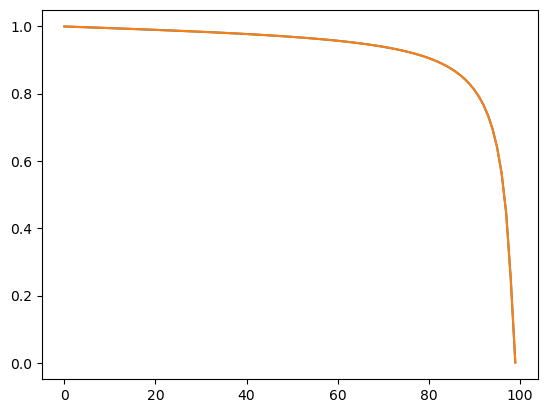

In [70]:
plt.plot(ddpm_noise_scheduler.alphas)
plt.plot(ddim_noise_scheduler.alphas)